In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/russian/'

In [3]:
!ls {PATH}

item_categories.csv      sales_train.csv          shops.csv
items.csv                sales_train.csv.gz       test.csv
joined                   sample_submission.csv    test.csv.gz
models                   sample_submission.csv.gz tmp


In [4]:
import os

In [5]:
import pandas as pd

In [ ]:
subm = pd.read_csv(f'{PATH}sample_submission.csv')
subm.head()

In [ ]:
test = pd.read_csv(f'{PATH}test.csv')
test.head()

In [ ]:
subm.shape,test.shape

In [6]:
tables = [pd.read_csv(f'{PATH}{f}.csv', low_memory=False) for f in ['item_categories', 'items', 'shops', 'sales_train']]

In [7]:
for t in tables: display(t.head())

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
#for t in tables: display(DataFrameSummary(t).summary())

In [8]:
item_cat, items, shops, train = tables

# Join tables
- Drop 'item_name' and we don't need 'item_category_name' since they are represented by 'item_id' and 'item_category_id' respectively
- Dropping date column to start with the simplest data

In [9]:
jointrain = pd.merge(train,items,how='left',on='item_id')

In [10]:
jointrain.drop(['item_name','date'],axis=1,inplace=True)

In [11]:
jointrain.head()
#display(DataFrameSummary(jointrain).summary())

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.0,37
1,0,25,2552,899.00,1.0,58
2,0,25,2552,899.00,-1.0,58
3,0,25,2554,1709.05,1.0,58
4,0,25,2555,1099.00,1.0,56


In [12]:
jointrain.to_feather(f'{PATH}joined')

In [13]:
!ls {PATH}

item_categories.csv      sales_train.csv          shops.csv
items.csv                sales_train.csv.gz       test.csv
joined                   sample_submission.csv    test.csv.gz
models                   sample_submission.csv.gz tmp


In [14]:
train = pd.read_feather(f'{PATH}joined')

In [15]:
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.0,37
1,0,25,2552,899.00,1.0,58
2,0,25,2552,899.00,-1.0,58
3,0,25,2554,1709.05,1.0,58
4,0,25,2555,1099.00,1.0,56


# Group by month

In [16]:
grouped = train.groupby(by=['date_block_num','shop_id','item_id'], sort=False)

In [17]:
traingroup = grouped.agg({'item_price':np.mean, 'item_cnt_day':np.sum, 'item_category_id':np.mean}).reset_index().rename(columns={'item_cnt_day':'item_cnt_month'})
#DataFrameSummary(traingroup).summary()

In [18]:
cat_vars = ['date_block_num', 'shop_id', 'item_id', 'item_category_id']

In [19]:
for column in cat_vars: traingroup[column] = traingroup[column].astype('category')
#Rearrange columns
traingroup = traingroup[['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_price', 'item_cnt_month']]
display(traingroup.head())
display(traingroup.tail())
#DataFrameSummary(traingroup).summary()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month
0,0,59,22154,37,999.00,1.0
1,0,25,2552,58,899.00,0.0
2,0,25,2554,58,1709.05,1.0
3,0,25,2555,56,1099.00,1.0
4,0,25,2564,59,349.00,1.0


,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month
1609119,33,25,7409,55,299.0,3.0
1609120,33,25,7393,55,349.0,1.0
1609121,33,25,7384,55,749.0,1.0
1609122,33,25,7459,55,349.0,1.0
1609123,33,25,7440,57,299.0,1.0


In [28]:
traingroup.to_feather(f'{PATH}grouped')

In [29]:
traingroup = pd.read_feather(f'{PATH}grouped')

In [30]:
traingroup.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month
0,0,59,22154,37,999.00,1.0
1,0,25,2552,58,899.00,0.0
2,0,25,2554,58,1709.05,1.0
3,0,25,2555,56,1099.00,1.0
4,0,25,2564,59,349.00,1.0


## Remove zeros and negative values

In [31]:
print(traingroup.shape)
traingroup = traingroup[traingroup.item_cnt_month.values > 0]
traingroup.shape

(1609124, 6)


(1605626, 6)

# Get validation set
- The last month will be the validation set

In [32]:
val_idx = traingroup[traingroup.date_block_num.values == 33].index
val_idx

Int64Index([1577593, 1577594, 1577595, 1577596, 1577597, 1577598, 1577599,
            1577600, 1577601, 1577602,
            ...
            1609114, 1609115, 1609116, 1609117, 1609118, 1609119, 1609120,
            1609121, 1609122, 1609123],
           dtype='int64', length=31471)

## Get smaller sample

In [82]:
traingroup_sample = traingroup[(traingroup.date_block_num.values==31)| (traingroup.date_block_num.values==32)|(traingroup.date_block_num.values==33)].reset_index(drop=True).copy()
traingroup_sample.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month
0,31,42,4261,30,299.0,3.0
1,31,46,12752,37,499.0,1.0
2,31,46,13556,61,2499.0,1.0
3,31,46,12805,40,169.0,1.0
4,31,46,12828,40,99.0,2.0


In [83]:
val_idx_samp = traingroup_sample[traingroup_sample.date_block_num.values == 33].index

In [84]:
val_idx_samp

Int64Index([63029, 63030, 63031, 63032, 63033, 63034, 63035, 63036, 63037,
            63038,
            ...
            94490, 94491, 94492, 94493, 94494, 94495, 94496, 94497, 94498,
            94499],
           dtype='int64', length=31471)

# Prepare data for DL

In [85]:
df, y, nas, mapper = proc_df(traingroup_sample, 'item_cnt_month', do_scale=True)

In [86]:
yl = np.log(y).astype(np.float32)
y, yl

(array([3., 1., 1., 1., 2., 1., 1., 1., 1., 3., 1., 2., 1., 2., 2., 1., 1., 1., 1., 1., ..., 1., 1., 1., 1.,
        1., 3., 2., 1., 1., 1., 1., 2., 1., 1., 1., 3., 1., 1., 1., 1.]),
 array([1.09861, 0.     , 0.     , 0.     , 0.69315, 0.     , 0.     , 0.     , 0.     , 1.09861, 0.     ,
        0.69315, 0.     , 0.69315, 0.69315, 0.     , 0.     , 0.     , 0.     , 0.     , ..., 0.     ,
        0.     , 0.     , 0.     , 0.     , 1.09861, 0.69315, 0.     , 0.     , 0.     , 0.     , 0.69315,
        0.     , 0.     , 0.     , 1.09861, 0.     , 0.     , 0.     , 0.     ], dtype=float32))

In [87]:
np.exp(np.log(0))

/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


0.0

In [88]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['item_price'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

In [89]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    y_pred = inv_y(y_pred)
    pct_var = (targ - y_pred)/targ
    return math.sqrt((pct_var**2).mean())

In [90]:
max_log_y = np.log(np.max(y))
y_range = (0, max_log_y*1.2)
y_range

(0, 9.264021528518693)

# Time to learn

In [91]:
md = ColumnarModelData.from_data_frame(PATH,val_idx_samp, df, yl, cat_vars, bs=128)

In [92]:
cat_sz = [(c, len(traingroup[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('date_block_num', 35),
 ('shop_id', 61),
 ('item_id', 21808),
 ('item_category_id', 85)]

In [93]:
emb_szs = [(c, min(50,(c+1)//2)) for _,c in cat_sz]
emb_szs

[(35, 18), (61, 31), (21808, 50), (85, 43)]

In [94]:
learn = md.get_learner(emb_szs, 1, 0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [95]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.496786   0.573496  



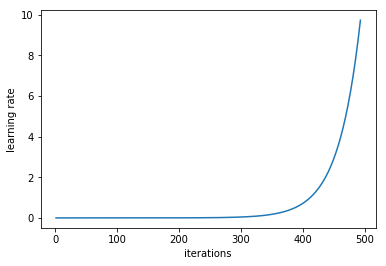

In [98]:
learn.sched.plot_lr()

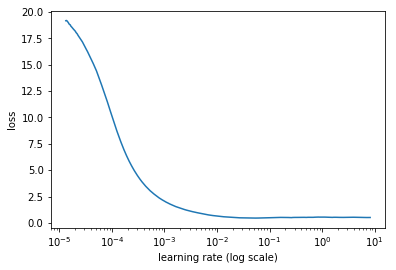

In [99]:
learn.sched.plot()

In [102]:
lr = 1e-4
learn.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                   
    0      0.376685   0.426473   0.60307   
    1      0.260257   0.382931   0.860916                    
    2      0.20382    0.399472   1.143945                    



[0.39947179591006865, 1.1439449691284118]